In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

%load_ext autoreload
%autoreload 1
%aimport atfml
%aimport atfml.bundles

In [2]:
import numpy as np
from collections import Counter

# https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt
def build_leo_tolstoy_dataset(path='/home/usman/data/char_lstm/warpeace_input.txt', 
                              n_data = 10000, window=10, batch_size=100):
    with open(path) as file:
        string = (''.join([next(file) for x in range(n_data)]))[1:].replace('\n', ' ')
    charset = list(zip(*Counter(string).most_common(70)))[0]
    ch_idx = lambda ch: charset.index(ch) + 1 if ch in charset else 0
    X_list, y_list = [], []
    for substr, target_char in [(string[i:i+window], string[i+window]) for i in range(n_data)]:
        x_row = [ch_idx(char) for char in substr]
        y = ch_idx(target_char)
        X_list.append(x_row)
        y_list.append(y)
    n_batches = int(n_data/batch_size)
    X = np.array(X_list)[:n_batches*batch_size]
    y = np.array(y_list)[:n_batches*batch_size]
    
    return ([{'X': X_batch, 'y': y_batch} 
            for X_batch, y_batch 
            in zip(np.split(X, n_batches, axis=0), 
                   np.split(y, n_batches, axis=0))], 
            
            {'charset_size': len(charset), 
             'mapping': dict(zip(charset, range(len(charset)))),
             'back_mapping': dict(zip(range(len(charset)), charset))}
           )

def prediction_into_string(pred, data_spec, err = '#'):
    if err in data_spec['mapping'].keys():
        raise ValueError('Wow, change err, it should not be in the mapping')
    
    bm = data_spec['back_mapping']
    return ''.join([(bm[n-1] if n > 0 else err) for n in pred.tolist()])

In [3]:
%%writefile ../bundles/lstm_decoder.py

# defined in atfml/examples/Char_LSTM.ipynb
from atfml.core import UnitBundle
from atfml.utils import inits

from atfml.bundles.lstm_encoder import LSTMEncoder

class LSTMDecoder(UnitBundle):
    def __init__(self, bk, name, n_hidden_dim, n_input_dim, n_steps, output_to_input_connection=True):
        self.n_steps = n_steps
        self.n_hidden_dim = n_hidden_dim
        self.o_to_i = output_to_input_connection
        
        w_width = n_input_dim + n_hidden_dim
        arg_dict = {
            'name': name,
            'weight_template': {
                'x_0': {'shape': (n_input_dim, ) },
                'c_0': {'shape': (n_hidden_dim, ) },
                'W_i': {'shape': (w_width, n_hidden_dim), 'init_method': inits.identity_repeat_init },
                'b_i': {'shape': (n_hidden_dim, ) },
                'W_c': {'shape': (w_width, n_hidden_dim), 'init_method': inits.identity_repeat_init },
                'b_c': {'shape': (n_hidden_dim, ) },
                'W_f': {'shape': (w_width, n_hidden_dim), 'init_method': inits.identity_repeat_init },
                'b_f': {'shape': (n_hidden_dim, ) },
                'W_o': {'shape': (w_width, n_hidden_dim), 'init_method': inits.identity_repeat_init },
                'b_o': {'shape': (n_hidden_dim, ) },
                'V_c': {'shape': (n_hidden_dim, n_hidden_dim), 
                        'init_method': inits.identity_repeat_init },
            },
            'data_template': {
                'X_expected': ('batch_size', self.n_steps, n_input_dim),
                'H_0': ('batch_size', n_hidden_dim),
            }
        }
        super().__init__(bk, **arg_dict)
        
    def _func(self, theta, data, const):
        """ same as LSTM as in LSTMBundle """
        np = None
        bk = self.bk
        h_prev = data.H_0
        c_prev = bk.repeat(theta.c_0[bk.newaxis, :], const.batch_size, axis=0)
        X_0 = bk.repeat(theta.x_0[bk.newaxis, :], const.batch_size, axis=0)
        if self.o_to_i:
            X_effective = bk.concatenate([X_0[:, bk.newaxis, :], data.X_expected[:, :-1, :]], axis=1)
        else:
            X_effective = bk.repeat(X_0[:, bk.newaxis, :], self.n_steps, axis=1)
      
        decoded_list = []
        sigmoid = lambda x: x/(1+bk.abs(x+1e-20))
        for t in range(self.n_steps):
            x_t = X_effective[:, t, :]
            concat_h_x = bk.concatenate([h_prev, x_t], axis=1)
            i_t = sigmoid(bk.dot(concat_h_x, theta.W_i) + theta.b_i[bk.newaxis, :])
            c_tld_t = sigmoid(bk.dot(concat_h_x, theta.W_c) + theta.b_c[bk.newaxis, :])
            f_t = sigmoid(bk.dot(concat_h_x, theta.W_f) + theta.b_f[bk.newaxis, :])
            c_t = bk.multiply(i_t, c_tld_t) + bk.multiply(f_t, c_prev)
            o_t = sigmoid(bk.dot(concat_h_x, theta.W_o) + bk.dot(c_t, theta.V_c) 
                          + theta.b_o[bk.newaxis, :])
            h_t = bk.multiply(o_t, bk.tanh(c_t))
            h_prev = h_t
            c_prev = c_t
            
            decoded_list.append(h_prev)
            
        decoded = bk.concatenate([x[:, bk.newaxis, :] for x in decoded_list], axis=1)
        bk.assert_arr_shape({decoded.shape: (const.batch_size, self.n_steps, self.n_hidden_dim)})
        
        return decoded

Overwriting ../bundles/lstm_decoder.py


Weight shapes are: {'decoder__b_i': (100,), 'decoder__c_0': (100,), 'decoder__x_0': (100,), 'encoder__W_c': (200, 100), 'encoder__b_f': (100,), 'decoder__W_i': (200, 100), 'encoder__V_c': (100, 100), 'encoder__W_o': (200, 100), 'encoder__b_c': (100,), 'decoder__W_o': (200, 100), 'decoder__W_f': (200, 100), 'encoder__W_f': (200, 100), 'encoder__c_0': (100,), 'E': (70, 100), 'decoder__b_c': (100,), 'encoder__b_i': (100,), 'encoder__W_i': (200, 100), 'decoder__V_c': (100, 100), 'decoder__b_f': (100,), 'decoder__W_c': (200, 100), 'encoder__h_0': (100,), 'encoder__b_o': (100,), 'decoder__b_o': (100,)}, n_total_params: 188200
FAST_COMPILE
Building learning step function and gradient .... done
Building  score.. done
Building  predict.. done
Building  loss.. done
Charset:  70
0  1.535e+04     0.1707
>>  warn you, if you don't tell m | hc'PPotot ,t' tot t''oEhthsd,t
50       8470      0.245
>>  believe a word that Hardenbur |  huclllerEnwhto thet hene rdes
100       7161      0.388
>> But I war

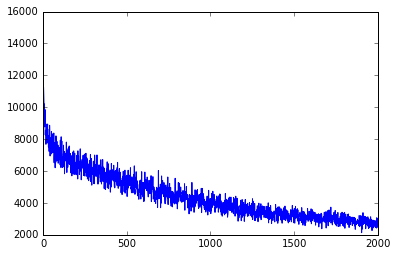

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
from atfml.core import AutoGradBackend, TheanoBackend
import atfml.utils as utils
from atfml.utils import inits, behaviours as bhvs
from atfml.bundles.lstm_encoder import LSTMEncoder
from atfml.bundles.lstm_decoder import LSTMDecoder

# bk = AutoGradBackend()
bk = TheanoBackend()

class Seq2SeqAutoencoder(bk.ModelLoss):
    def __init__(self, *, vocab_size, n_hidden_dim, seq_len, data_spec):      
        self.n_hidden_dim = n_hidden_dim
        self.n_embedding_dim = n_hidden_dim
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.data_spec = data_spec
        
        arg_dict = {
            'data_template': {
                'X': {'shape':('batch_size', self.seq_len), 'dtype': 'int64' },
            },
            'default_init_method': inits.gaussian_init_with(mu=0, std=1),
            'weight_template': {
                'E': {'shape':(self.vocab_size, self.n_embedding_dim) },
            },
            'weight_bundles': {
                'encoder': {'class': LSTMEncoder, 
                            'args': {'n_hidden_dim':n_hidden_dim, 
                                     'n_input_dim': self.n_embedding_dim, 
                                     'n_steps': seq_len} },
                'decoder': {'class': LSTMDecoder,
                            'args': {'n_hidden_dim':n_hidden_dim, 
                                     'n_input_dim': self.n_embedding_dim, 
                                     'n_steps': seq_len,
                                     'output_to_input_connection': True}},
                
            },
            'optimization_method': {'name': 'adam', 'learning_rate': 0.005, 'clip': 100},
            'behaviours': {
                'loss': bhvs.LossLogBehaviour(),
            }
        }
        super().__init__(**arg_dict)
    
    @bk.export
    def predict(self, theta, data, const):
        np = None # for safety
        embedded_X = theta.E[data.X] # [batch_size, seq_len, n_hidden_him]
        h_last = self.bundles.encoder.apply(theta, {'X':embedded_X}) # [batch_size, n_hidden_dim]
        X_pred = self.bundles.decoder.apply(theta, {'X_expected': embedded_X, 
                                                    'H_0': h_last}) # as embedded_X
        ## [batch_size, seq_len, n_hidden_dim] * [n_hidden, vocab_size]
        ## -> [batch_size, seq_len, vocab_size]
        output_seq_prob = bk.ops.softmax(bk.dot(X_pred, theta.E.T) )
        bk.assert_arr_shape({output_seq_prob.shape: (const.batch_size, self.seq_len, self.vocab_size)})
        return output_seq_prob
    
    def loss(self, theta, data, const):
        np = None # for safety
        output_seq_prob = self.raw.predict(theta, data, const)
        ## output_seq_prob: [batch_size, seq_len, vocab_size], X: [batch_size, seq_len]
        ## correct_probs: [batch_size, seq_len]
        ii, jj = bk.indices((const.batch_size, self.seq_len))
        correct_probs = output_seq_prob[ii, jj, data.X[ii, jj]]
        loss = bk.sum( -bk.log( correct_probs ) )
        return loss
    
    @bk.export
    def score(self, theta, data, const):
        np = None # for safety
        output_prob = self.raw.predict(theta, data, const)
        X_pred = bk.argmax(output_prob, axis=2)
        score = bk.sum( bk.isclose(X_pred, data.X), dtype='float32')/const.batch_size/self.seq_len
        return score
    
    def step_callback(self, loss_val, theta, data, const, info):
        bk = None
        if info['n_iter'] % 50 == 0:
            score_val = self.compiled.score(theta, data, const)
            print('%d %10.4g %10.4g' % (info['n_iter'], loss_val, score_val))
            self.generate_output(theta, data, const, info)
            
    def generate_output(self, theta, data, const, info):
        ## print random prediction as a string
        i_to_check = np.random.randint(const.batch_size)
        data_line = data.X[i_to_check].reshape((1, -1))
        original_string = prediction_into_string(data_line.ravel(), self.data_spec)

        small_data = utils.to_record({'X': data_line}) # we don't care about y
        local_const = utils.to_record({'batch_size': 1}) # dirty stub :(
        output_prob = self.compiled.predict(theta, small_data, local_const)
        X_pred = np.argmax(output_prob, axis=2).ravel()

        reconstructed_string = prediction_into_string(X_pred, self.data_spec)
        print('>>', original_string, '|', reconstructed_string)

def test_lstm_on_leo():
    seq_len = 30
    data, data_spec = build_leo_tolstoy_dataset(n_data = 10000, window=seq_len, batch_size=100)
    model = Seq2SeqAutoencoder(n_hidden_dim=100, vocab_size=data_spec['charset_size'], 
                               seq_len=seq_len, data_spec=data_spec)
    print('Charset: ', data_spec['charset_size'])
    only_X_data = [{'X': data_i['X']} for data_i in data]
    best_theta = model.fit(only_X_data, n_max_steps=2000)
    plt.plot(model.behaviours.loss.log)
    plt.show()
    
test_lstm_on_leo()